In [100]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import math
import pickle
from openpyxl import load_workbook

In [4]:
data = pd.read_csv('../data/oecd_disposable_income_etc.csv', low_memory = False)
ppp = pd.read_csv('../data/ppp.csv', low_memory = False)
# haq = pd.read_csv('../data/HAQ_1.csv', low_memory = False)

In [145]:
topics = data['Measure'].unique().tolist()
mdi = [ x for x in topics if 'mean disposable income' in x ]
shnm = [ x.split(':')[0] for x in mdi]
print(mdi)
print(shnm)

['Age group 0-17: mean disposable income (current prices)', 'Age group 18-25: mean disposable income (current prices)', 'Age group 26-40: mean disposable income (current prices)', 'Age group 41-50: mean disposable income (current prices)', 'Age group 51-65: mean disposable income (current prices)', 'Age group 66-75: mean disposable income (current prices)', 'Age group 76+: mean disposable income (current prices)', 'All age groups: mean disposable income (current prices)', 'All working-age household types: mean disposable income (current prices)']
['Age group 0-17', 'Age group 18-25', 'Age group 26-40', 'Age group 41-50', 'Age group 51-65', 'Age group 66-75', 'Age group 76+', 'All age groups', 'All working-age household types']


In [123]:
data['Measure'].unique()

array(['Gini (disposable income, post taxes and transfers)',
       'Consumer Price Index (base 2010=100)',
       'Age group 0-17: Poverty rate after taxes and transfers',
       'Total earnings (current prices)',
       'Income from self-employment (current prices)',
       'Taxes and social security contributions paid directly by households (Current prices)',
       'Age group 0-17: mean disposable income (current prices)',
       'Age group 18-25: mean disposable income (current prices)',
       'Capital income (current prices)',
       'Age group 18-25: Poverty rate after taxes and transfers',
       'Purchasing Power Parities for private consumption',
       'Standard error Gini (post taxes and transfers)',
       'Mean disposable income (current prices)',
       'Gini (market income, before taxes and transfers)',
       'Age group 26-40: Poverty rate after taxes and transfers',
       'Income from self-employment and from goods produced for own consumption (current prices)',
   

In [124]:
fnm = 'OECD_mean_disposable_income.xlsx'

In [136]:
mdi_dfs = []
for nm in mdi:
    mdi_dfs.append(data.loc[data['Measure'] == nm])

In [138]:
# Get data for latest year
mdi_dfs2 = []
for dfs in mdi_dfs:
    idx = dfs.groupby(['LOCATION'])['Year'].transform(max) == dfs['Year']
    tmp = dfs[idx]
    tmp = tmp.dropna(subset = ['Unit', 'Value', 'LOCATION'])
    mdi_dfs2.append(tmp)
    
mdi_dfs2[0].head()

,LOCATION,Country,MEASURE,Measure,AGE,Age group,DEFINITION,Definition,METHODO,Methodology,...,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
47,AUS,Australia,INCAC1,Age group 0-17: mean disposable income (curren...,TOT,Total population,CURRENT,Current definition,METH2012,New income definition since 2012,...,2018,AUD,Australian Dollar,0,Units,NaN,NaN,55881.0,NaN,NaN
468,AUT,Austria,INCAC1,Age group 0-17: mean disposable income (curren...,TOT,Total population,CURRENT,Current definition,METH2012,New income definition since 2012,...,2017,EUR,Euro,0,Units,NaN,NaN,26872.0,NaN,NaN
1069,BEL,Belgium,INCAC1,Age group 0-17: mean disposable income (curren...,TOT,Total population,CURRENT,Current definition,METH2012,New income definition since 2012,...,2017,EUR,Euro,0,Units,NaN,NaN,27253.0,NaN,NaN
2195,CAN,Canada,INCAC1,Age group 0-17: mean disposable income (curren...,TOT,Total population,CURRENT,Current definition,METH2012,New income definition since 2012,...,2017,CAD,Canadian Dollar,0,Units,NaN,NaN,47030.0,NaN,NaN
3277,CZE,Czech Republic,INCAC1,Age group 0-17: mean disposable income (curren...,TOT,Total population,CURRENT,Current definition,METH2012,New income definition since 2012,...,2017,CZK,Czech Koruna,0,Units,NaN,NaN,290220.0,NaN,NaN


In [139]:
for dfs in mdi_dfs2:
    print(dfs['LOCATION'].duplicated().any())
    print(dfs.shape)

False
(44, 21)
False
(44, 21)
False
(44, 21)
False
(44, 21)
False
(44, 21)
False
(44, 21)
False
(43, 21)
False
(40, 21)
False
(35, 21)


In [128]:
print(ppp.loc[ppp['LOCATION'] == 'AUS'].loc[ppp['TIME'] == 1960]['Value'].values[0])
print(1960 in ppp.loc[ppp['LOCATION'] == 'AUS']['TIME'].values)

0.700946
True


In [140]:
for dfs in mdi_dfs2:
    dfs['Value_USD_PPP'] = dfs['Value']
# data3['haq'] = data3['Value']

In [141]:
for dfs in mdi_dfs2:
    for k, (val, cc, yr) in enumerate( zip( dfs['Value'], dfs['LOCATION'], dfs['Year'] ) ):
        tmp = yr
        found = tmp in ppp.loc[ppp['LOCATION'] == cc]['TIME'].values
        while( not found ): #check if PPP data is not available for that year
            tmp = tmp - 1
            found = tmp in ppp.loc[ppp['LOCATION'] == cc]['TIME'].values
        ppp_val = ppp.loc[ppp['LOCATION'] == cc].loc[ppp['TIME'] == tmp]['Value'].values[0]    
        conv_factor = 1.0 / ppp_val
        dfs['Value_USD_PPP'].iloc[k] = val * conv_factor

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [148]:
with pd.ExcelWriter(fnm, engine = "openpyxl", mode = "a") as writer:
    for dfs, nm in zip(mdi_dfs2, shnm):
        tmp = dfs.filter(['LOCATION', 'Country', 'Year', 'Unit', 'Value', 'Value_USD_PPP'], axis = 1)
        tmp = tmp.rename(columns = {'LOCATION' : 'Country Code', 'Value_USD_PPP' : 'Normalized_Value_USD_PPP'})
        tmp.to_excel(writer, sheet_name = nm, index = False)

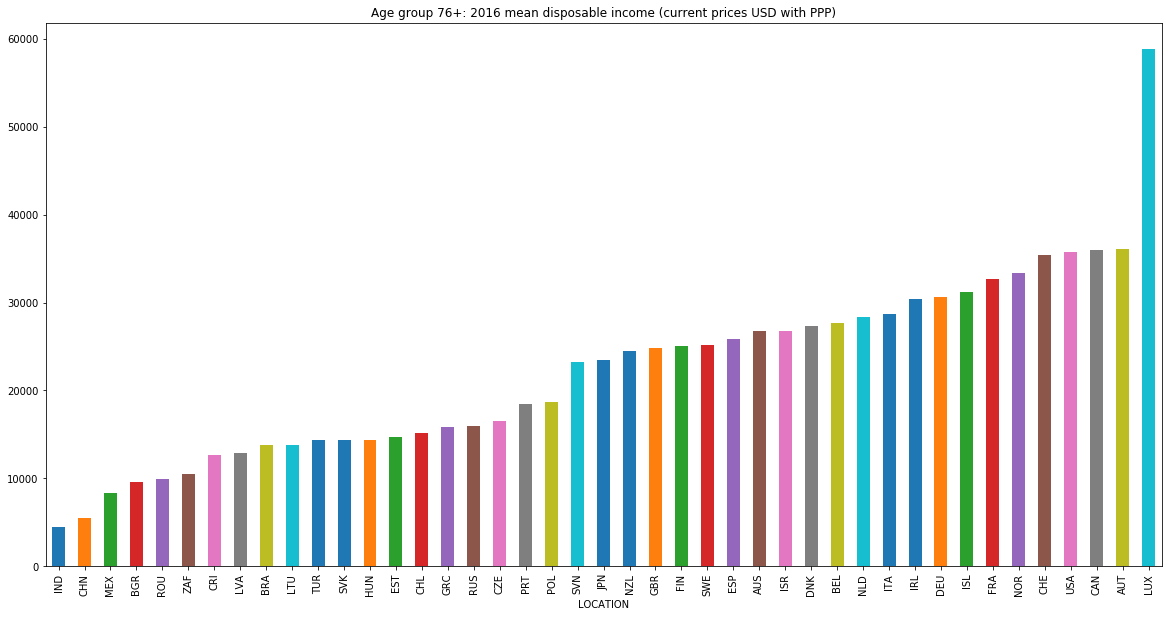

In [149]:
ax = mdi_dfs2[6].sort_values(by=['Value_USD_PPP']).plot(x = 'LOCATION', y = 'Value_USD_PPP', kind = 'bar', legend = False, title = 'Age group 76+: 2016 mean disposable income (current prices USD with PPP)')
plt.rcParams['figure.figsize'] = [20, 10]
plt.savefig('test.png', bbox_inches='tight')